In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sep
from scarlet import Starlet
from scarlet_extensions.initialization.detection import mad_wavelet
import warnings
warnings.filterwarnings('ignore')

In [2]:
def makeCatalog(images, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    This function is used for detection before running scarlet.
    It is particularly useful for stellar crowded fields and for detecting high frequency features.
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    
    hr_images = images / np.sum(images, axis=(1, 2))[:, None, None]
    # Detection image as the sum over all images
    detect_image = np.sum(hr_images, axis=0)

    if np.size(detect_image.shape) == 3:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet.from_image(detect_image.mean(axis=0), lvl=4).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = Starlet(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = Starlet.from_image(detect_image).coefficients
            
            detect = wave_detect[0]
        else:
            detect = detect_image

    bkg = sep.Background(images[0])
    catalog = sep.extract(images[0], lvl, err=bkg.globalrms)

    
    bg_rms = mad_wavelet(images)

    return catalog, bg_rms



In [3]:
file = np.load("data/ZFT_training_images_26k_iband_time_series_images_EPL.npz", allow_pickle = True)
file_full = np.load("data/ZTF_training_images_26k_iband_image_properties_EPL.npz", allow_pickle = True)
print(file_full.files)

['data_labels', 'z_source_list', 'point_amp_list', 'abs_mag_ps_list', 'app_mag_ps_list', 'theta_E_list', 'PSF_list', 'colour_param', 'stretch_param', 'max_time_delay', 'z_lens_list', 'ra_source_list', 'dec_source_list', 'magnification_list']


In [4]:
print(file.files)

time_images = file['images_time_series']
coadd = file['images_single']
peaks = file['images_peak']
labels = file['data_labels']

mags = file_full['app_mag_ps_list']


['images_time_series', 'images_single', 'images_peak', 'data_labels']


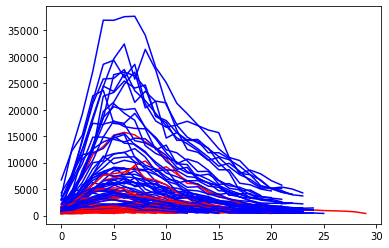

In [14]:
for indx, tim in enumerate(time_images[:100]):

    x_cat = []
    y_cat = []
    x2_cat = []
    y2_cat = []
    flux = []
    for im in tim:
        catalog, bg = makeCatalog(im[None], lvl=1, wave=False)
        try:
            x_cat.append(*catalog['x'])
            y_cat.append(*catalog['y'])
            x2_cat.append(*catalog['x2'])
            y2_cat.append(*catalog['y2'])
            flux.append(*catalog['cflux'])
        except:
            continue

    #plt.title(labels[indx])
    #plt.plot(np.array(x_cat), np.array(y_cat), 'o')
    #plt.show()
    #plt.plot( np.array(x2_cat), 'o')
    #plt.show()
    #plt.plot( np.array(y2_cat), 'o')
    #plt.show()
    #plt.plot(np.array(flux))
    #plt.show()
    if labels[indx][0] == 0:
        plt.plot(flux, 'b')
    else:
        plt.plot(flux, 'r')

plt.show()